# Echo State Networks

## References

- http://www.scholarpedia.org/article/Echo_state_network
- http://minds.jacobs-university.de/sites/default/files/uploads/papers/PracticalESN.pdf
- http://www.pdx.edu/sites/www.pdx.edu.sysc/files/Jaeger_TrainingRNNsTutorial.2005.pdf

In [1]:
%matplotlib inline

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from six.moves import range

import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

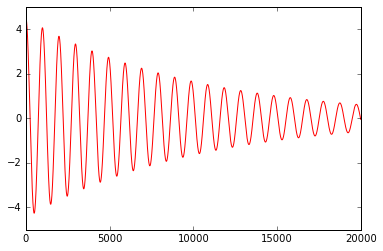

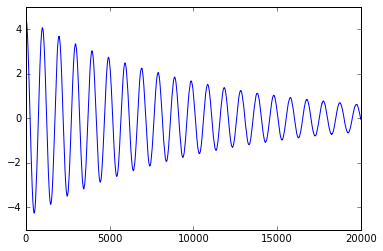

In [2]:
# This method adapted from Keras
# https://github.com/fchollet/keras/blob/master/examples/stateful_lstm.py
def gen_cosine_amp(amp=100, period=25, x0=0, xn=50000, step=1, k=0.0001):
    """Generates an absolute cosine time series with the amplitude
    exponentially decreasing
    Arguments:
        amp: amplitude of the cosine function
        period: period of the cosine function
        x0: initial x of the time series
        xn: final x of the time series
        step: step of the time series discretization
        k: exponential rate
    """
    cos = np.zeros(((xn - x0) * step, 1, 1))
    for i in range(len(cos)):
        idx = x0 + i * step
        cos[i, 0, 0] = amp * np.cos(idx / (2 * np.pi * period))
        cos[i, 0, 0] = cos[i, 0, 0] * np.exp(-k * idx)
    return cos

cos = gen_cosine_amp()
cos = cos.reshape((cos.shape[0], -1))
cos = (cos - cos.mean()) / cos.std()

X_train = cos[:30000, :]
X_test = cos[:20000, :]

input_dim = X_train.shape[1]
reservoir_size = 1024
leaking_rate = 0.2
init_len = 100

# Setting scale to lower value (e.g. 0.1) didn't work well
W_in = np.random.uniform(-1, 1, size=(input_dim, 1 + input_dim))
W_res = np.random.uniform(-1, 1, size=(reservoir_size, reservoir_size))

X = np.zeros((1 + input_dim + reservoir_size,
              X_train.shape[0] - init_len))
y = cos[(init_len + 1):(X_train.shape[0] + 1)].reshape((1, -1))

h = np.zeros((reservoir_size, 1))
for i in range(X_train.shape[0]):
    x = X_train[i]
    h = (1 - leaking_rate) * h + leaking_rate * np.tanh(np.dot(W_in, np.vstack((1, x))) + np.dot(W_res, h))
    if i >= init_len:
        X[:, i - init_len] = np.vstack((1, x, h))[:, 0]

reg = 1e-4
W_out = np.dot(np.dot(y, X.T),
               np.linalg.inv(np.dot(X, X.T) +
                             reg * np.eye(1 + input_dim + reservoir_size)))

y = np.zeros((X_test.shape[0], X_test.shape[1]))
x = X_train[-1]
for i in range(X_test.shape[0]):
    h = (1 - leaking_rate) * h + leaking_rate * np.tanh(np.dot(W_in, np.vstack((1, x))) + np.dot(W_res, h))
    x_ = np.dot(W_out, np.vstack((1, x, h)))
    y[i, :] = x_
    x = X_test[i] 

plt.plot(X_test, 'r')
plt.show()
plt.plot(y)